In [148]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

warnings.simplefilter("ignore")

plt.rcParams['figure.figsize'] = (12, 5)

                    count  mean   std   min   25%   50%   75%   max
acousticness      13129.0  0.52  0.38  0.00  0.10  0.57  0.92  1.00
danceability      13129.0  0.49  0.19  0.05  0.34  0.49  0.63  0.97
energy            13129.0  0.54  0.28  0.00  0.32  0.55  0.78  1.00
instrumentalness  13129.0  0.64  0.36  0.00  0.32  0.84  0.92  1.00
liveness          13129.0  0.19  0.16  0.03  0.10  0.12  0.21  0.98
speechiness       13129.0  0.10  0.14  0.02  0.04  0.05  0.09  0.97
valence           13129.0  0.44  0.28  0.00  0.20  0.42  0.67  1.00


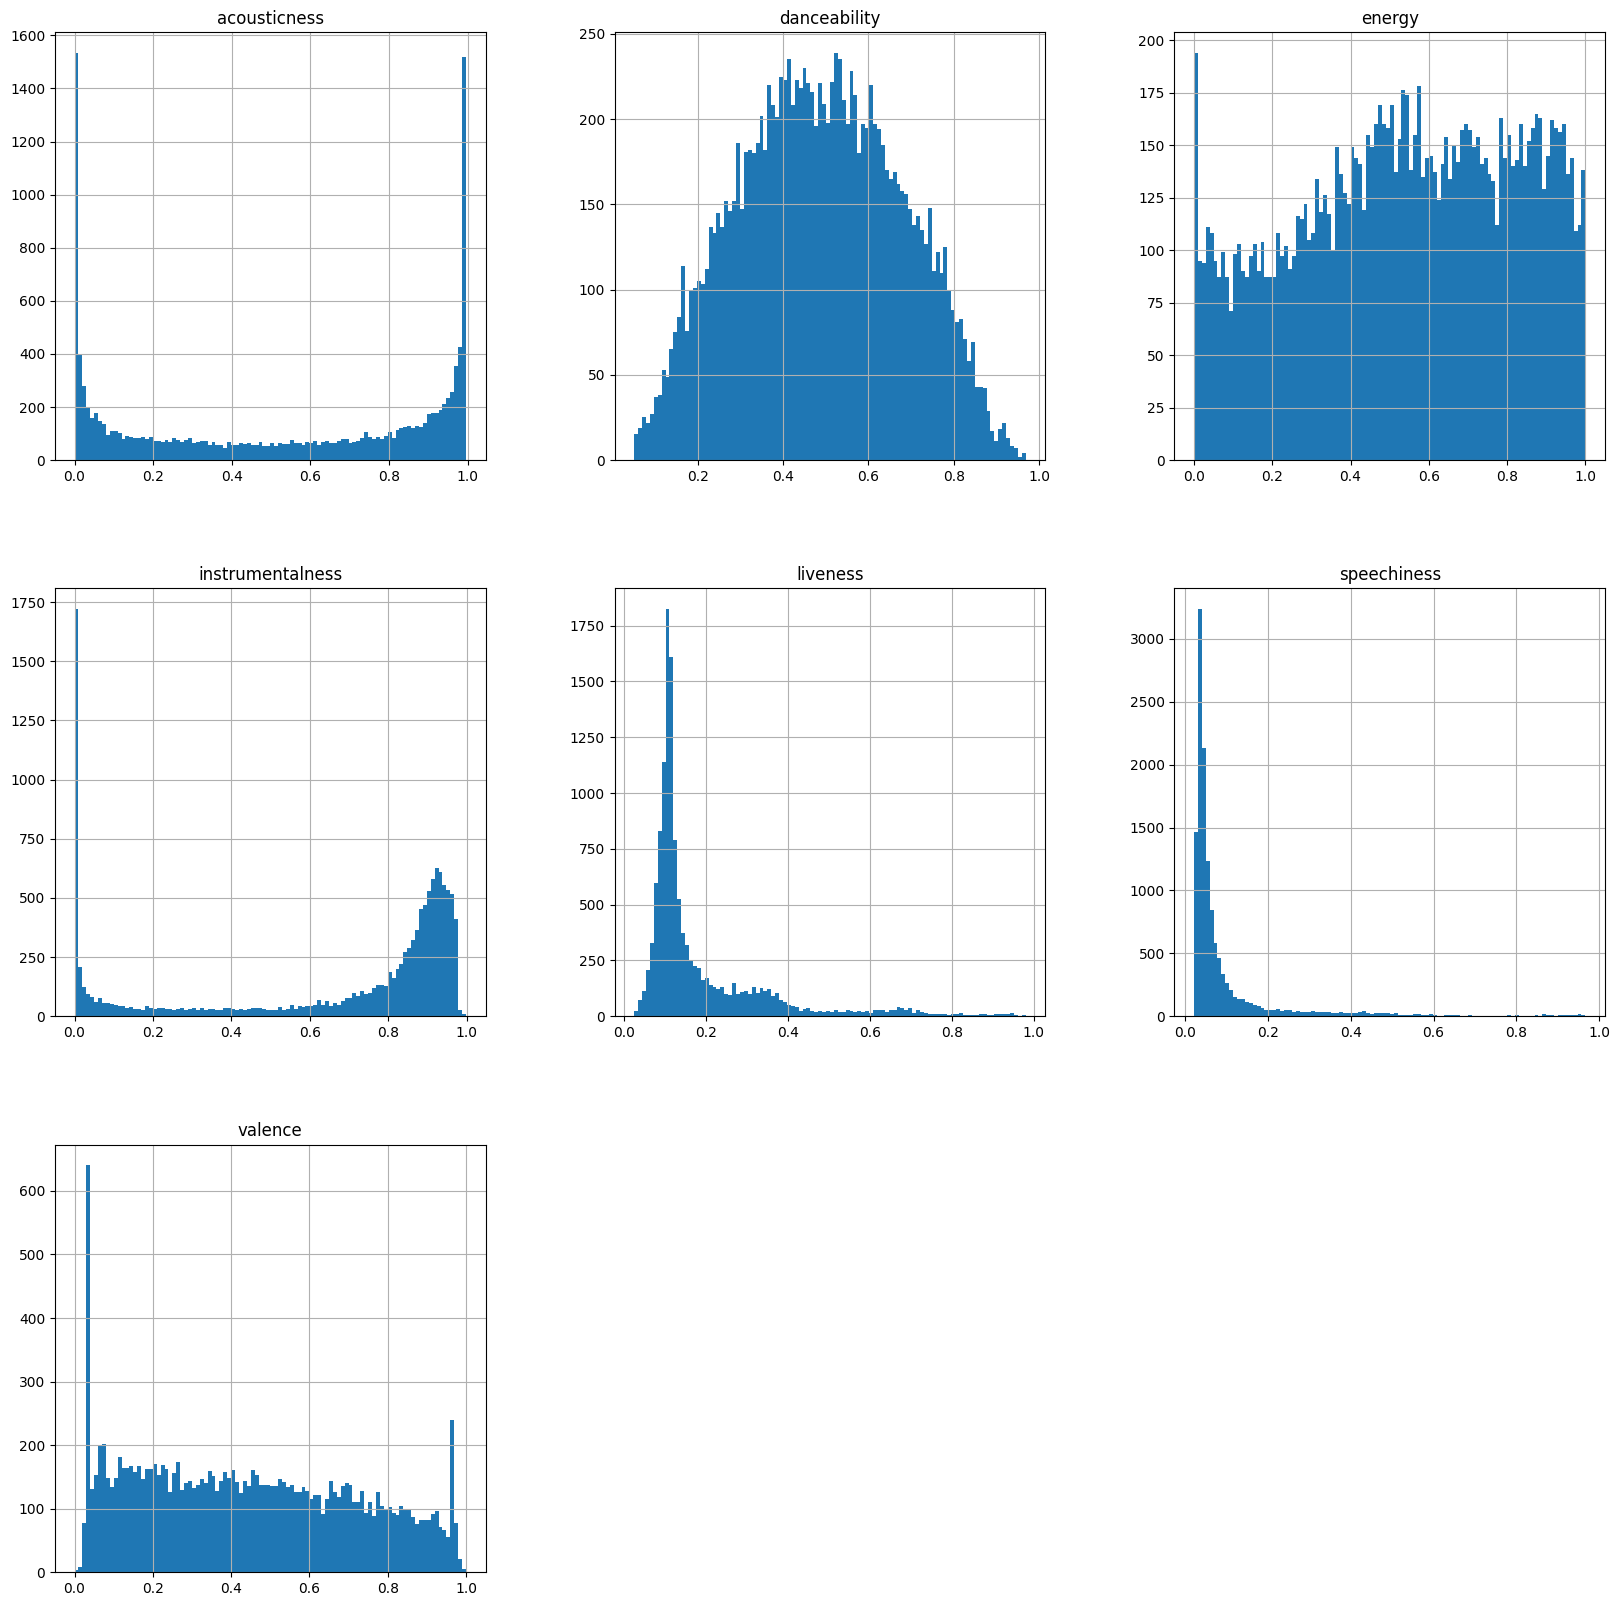

In [26]:
# extract the features from the echonest file
base_dir = '../A4/fma_metadata'  # change this to your own directory
echonest_raw = pd.read_csv(f'{base_dir}/echonest.csv', index_col=0, header=[0, 1, 2])

# extract only the target features
echonest_features = echonest_raw['echonest', 'audio_features']

# drop tempo (will be a model input not target)
echonest_features.drop('tempo', axis=1, inplace=True)

# print histogram to see the distribution of values
echonest_features.hist(bins=100, figsize=(20, 20));

print(echonest_features.describe().T.round(2))

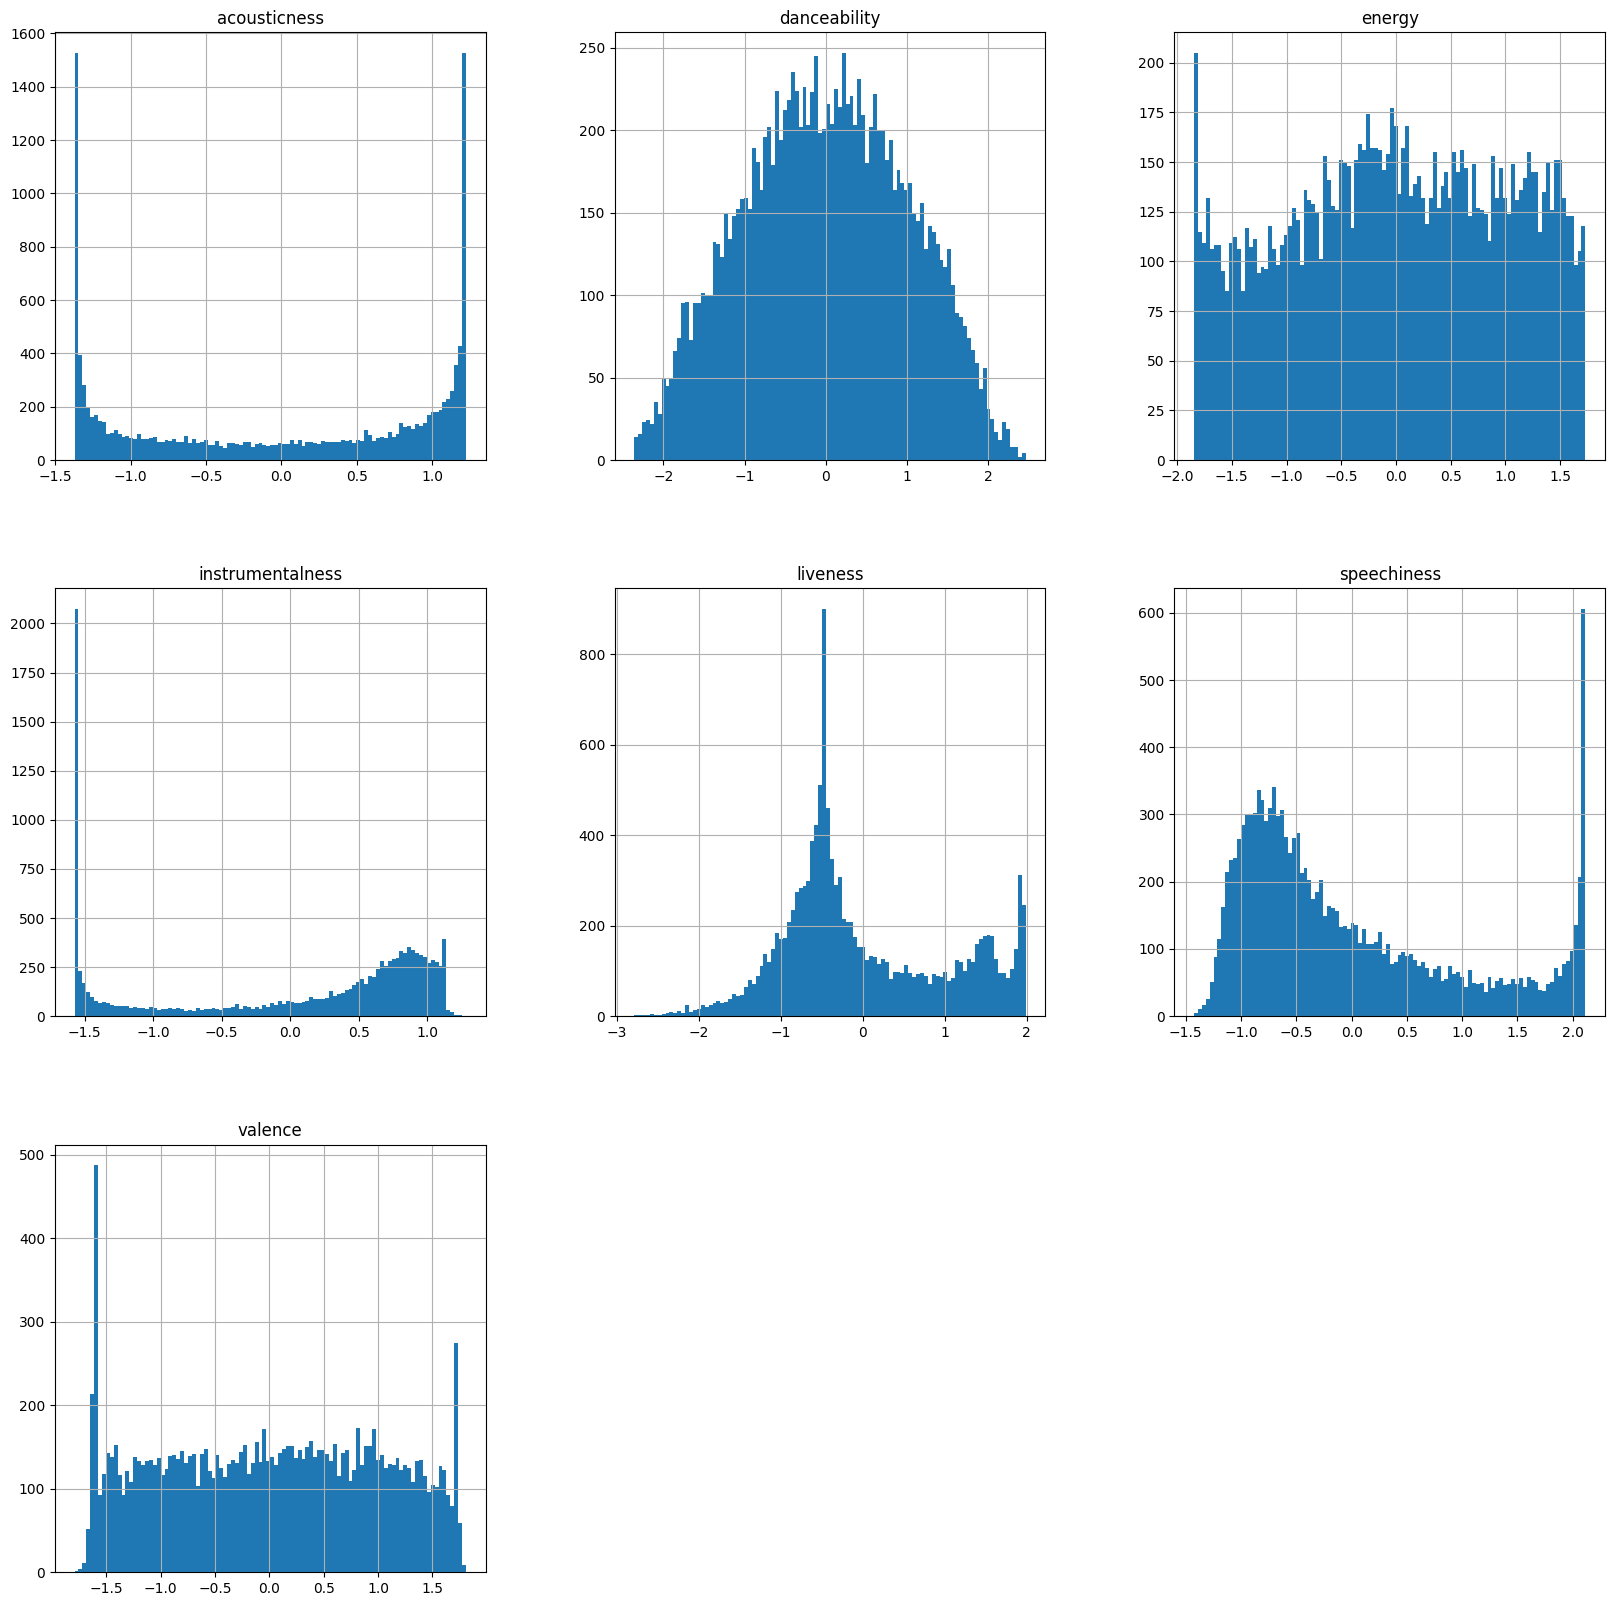

In [27]:
# log scale the echonest features to make them more normally distributed
pt = PowerTransformer()
en_feats_logscale = pd.DataFrame(pt.fit_transform(echonest_features),
                                 columns=echonest_features.columns,
                                 index=echonest_features.index)

en_feats_logscale.hist(bins=100, figsize=(20, 20));

### Thresholding Echonest Scores
Converting echonest numeric scores to binary tags by thresholding at: $mean + coeff * std$

In [102]:
coeff = 0.5
binary_tags = en_feats_logscale.apply(lambda x: (x > x.mean() + coeff*x.std()).astype(int), axis=0)

print(binary_tags.describe().T.round(2))

# save the binary targets to a csv file
EN_feature_mapping = {
    "acousticness": "acoustic",
    "danceability": "danceable",
    "energy": "energetic",
    "instrumentalness": "instrumental",
    "liveness": "lively",
    "speechiness": "speechy",
    "valence": "happy"
}
binary_tags.rename(columns=EN_feature_mapping, inplace=True)
binary_tags.to_csv('data/echonest_labels.csv')

                    count  mean   std  min  25%  50%  75%  max
acousticness      13129.0  0.43  0.49  0.0  0.0  0.0  1.0  1.0
danceability      13129.0  0.33  0.47  0.0  0.0  0.0  1.0  1.0
energy            13129.0  0.35  0.48  0.0  0.0  0.0  1.0  1.0
instrumentalness  13129.0  0.48  0.50  0.0  0.0  0.0  1.0  1.0
liveness          13129.0  0.29  0.46  0.0  0.0  0.0  1.0  1.0
speechiness       13129.0  0.27  0.44  0.0  0.0  0.0  1.0  1.0
valence           13129.0  0.35  0.48  0.0  0.0  0.0  1.0  1.0


### Build Dataset
- Feature extraction with Librosa for model inputs (X_train/X_test)
- Labelling tracks with genre and echonest tags (Y_train/Y_test)

In [104]:
def get_fnames():
    """ Get list of audio track file paths. """
    
    base_dir = '../A4/fma_medium_trimmed'  # change this to your own path
    fnames = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                fnames.append(file_path)
    return fnames

In [105]:
## UNCOMMENT THE FOLLOWING CODE TO BUILD DATASET FROM SCRATCH ##

# tag_df = pd.read_csv('data/echonest_labels.csv', index_col='track_id')

# targets = []  # echonest tags
# feats_mean_mfcc = []
# feats_std_mfcc = []
# feats_mean_chroma = []
# feats_std_chroma = []
# feats_tempo = []
# feats_mean_contrast = []
# feats_std_contrast = []
# feats_mean_mel = []
# feats_std_mel = []
# feats_mean_tonnetz = []
# feats_std_tonnetz = []
# feats_mean_rms = []
# feats_std_rms = []
# feats_mean_zcr = []
# feats_std_zcr = []

# total = 0
# skipped = 0

# # Iterate over audio files to extract features (model inputs) and targets/labels
# for idx, fname in enumerate(get_fnames()):
#     total += 1

#     # Check if the track ID is in tag_df
#     track_id = int(os.path.basename(fname).split(".")[0])
#     match = tag_df[tag_df.index == track_id]
#     if match.empty:
#         skipped += 1
#         continue
    
#     # Target for a track = echonest tags
#     echonest_tags = match.values.tolist()[0]
#     targets.append(echonest_tags)

#     # Load the audio file and extract the features
#     print(f'Extracting features for track {idx}', end='\r')
#     audio, srate = librosa.load(fname, res_type='kaiser_fast')
#     mfcc_matrix = librosa.feature.mfcc(y=audio, sr=srate, n_mfcc=40)
#     chroma_cqt = librosa.feature.chroma_cqt(y=audio, sr=srate, n_chroma=12)
#     tempo, _ = librosa.beat.beat_track(y=audio, sr=srate)
#     contrast = librosa.feature.spectral_contrast(y=audio, sr=srate, n_bands=6)
#     mel = librosa.feature.melspectrogram(y=audio, sr=srate, n_mels=64)
#     tonnetz = librosa.feature.tonnetz(y=audio, sr=srate)
#     rms = librosa.feature.rms(y=audio)
#     zcr = librosa.feature.zero_crossing_rate(y=audio)

#     mean_mfcc = np.mean(mfcc_matrix, axis=1)
#     std_mfcc = np.std(mfcc_matrix, axis=1)
#     mean_chroma = np.mean(chroma_cqt, axis=1)
#     std_chroma = np.std(chroma_cqt, axis=1)
#     mean_contrast = np.mean(contrast, axis=1)
#     std_contrast = np.std(contrast, axis=1)
#     mean_mel = np.mean(mel, axis=1)
#     std_mel = np.std(mel, axis=1)
#     mean_tonnetz = np.mean(tonnetz, axis=1)
#     std_tonnetz = np.std(tonnetz, axis=1)
#     mean_rms = np.mean(rms, axis=1)
#     std_rms = np.std(rms, axis=1)
#     mean_zcr = np.mean(zcr, axis=1)
#     std_zcr = np.std(zcr, axis=1)

#     feats_mean_mfcc.append(mean_mfcc)
#     feats_std_mfcc.append(std_mfcc)
#     feats_mean_chroma.append(mean_chroma)
#     feats_std_chroma.append(std_chroma)
#     feats_tempo.append(tempo)
#     feats_mean_contrast.append(mean_contrast)
#     feats_std_contrast.append(std_contrast)
#     feats_mean_mel.append(mean_mel)
#     feats_std_mel.append(std_mel)
#     feats_mean_tonnetz.append(mean_tonnetz)
#     feats_std_tonnetz.append(std_tonnetz)
#     feats_mean_rms.append(mean_rms)
#     feats_std_rms.append(std_rms)
#     feats_mean_zcr.append(mean_zcr)
#     feats_std_zcr.append(std_zcr)

# # save to disk to avoid re-computing
# np.save('features/targets.npy', targets)
# np.save('features/feats_mean_mfcc.npy', feats_mean_mfcc)
# np.save('features/feats_std_mfcc.npy', feats_std_mfcc)
# np.save('features/feats_mean_chroma.npy', feats_mean_chroma)
# np.save('features/feats_std_chroma.npy', feats_std_chroma)
# np.save('features/feats_tempo.npy', feats_tempo)
# np.save('features/feats_mean_contrast.npy', feats_mean_contrast)
# np.save('features/feats_std_contrast.npy', feats_std_contrast)
# np.save('features/feats_mean_mel.npy', feats_mean_mel)
# np.save('features/feats_std_mel.npy', feats_std_mel)
# np.save('features/feats_mean_tonnetz.npy', feats_mean_tonnetz)
# np.save('features/feats_std_tonnetz.npy', feats_std_tonnetz)
# np.save('features/feats_mean_rms.npy', feats_mean_rms)
# np.save('features/feats_std_rms.npy', feats_std_rms)
# np.save('features/feats_mean_zcr.npy', feats_mean_zcr)
# np.save('features/feats_std_zcr.npy', feats_std_zcr)

# print(f"\nSkipped {skipped}/{total} files")
# print(f"Dataset size: {len(targets)}")

Extracting features for track 24984
Skipped 19704/24985 files
Dataset size: 5281


In [106]:
## LOAD DATASET FROM DISK IF ALREADY COMPUTED ##

feats_mean_mfcc = np.load('features/feats_mean_mfcc.npy')
feats_std_mfcc = np.load('features/feats_std_mfcc.npy')
feats_mean_chroma = np.load('features/feats_mean_chroma.npy')
feats_std_chroma = np.load('features/feats_std_chroma.npy')
feats_tempo = np.load('features/feats_tempo.npy').reshape(-1, 1)
feats_mean_contrast = np.load('features/feats_mean_contrast.npy')
feats_std_contrast = np.load('features/feats_std_contrast.npy')
feats_mean_mel = np.load('features/feats_mean_mel.npy')
feats_std_mel = np.load('features/feats_std_mel.npy')
feats_mean_tonnetz = np.load('features/feats_mean_tonnetz.npy')
feats_std_tonnetz = np.load('features/feats_std_tonnetz.npy')
feats_mean_rms = np.load('features/feats_mean_rms.npy')
feats_std_rms = np.load('features/feats_std_rms.npy')
feats_mean_zcr = np.load('features/feats_mean_zcr.npy')
feats_std_zcr = np.load('features/feats_std_zcr.npy')

X = np.hstack([feats_mean_mfcc, feats_std_mfcc, feats_mean_chroma, feats_std_chroma, feats_tempo,
               feats_mean_contrast, feats_std_contrast, feats_mean_mel, feats_std_mel,
               feats_mean_tonnetz, feats_std_tonnetz, feats_mean_rms, feats_std_rms,
               feats_mean_zcr, feats_std_zcr])
print("X shape:", X.shape)

y = np.load('features/targets.npy')
print("y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X shape: (5281, 263)
y shape: (5281, 7)


### Classification
Model training and evaluation

In [161]:
def perform_grid_search_rf(X, y):
    """ Perform Grid Search to find the best hyperparameters for a single label. """
    
    pipeline = Pipeline([
        ('feature_selection', SelectFromModel(RandomForestClassifier())),
        ('classification', RandomForestClassifier())
    ])

    param_grid = {
        'feature_selection__threshold': ['0.7*mean'],
        'classification__n_estimators': [110],
        'classification__max_depth': [13],
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='f1', verbose=3)
    grid_search.fit(X, y)
    return grid_search.best_estimator_, grid_search.best_params_


def perform_grid_search_mlp(X, y):
    """ Perform Grid Search to find the best hyperparameters for a single label. """
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectFromModel(RandomForestClassifier())),
        ('classification', MLPClassifier())
    ])

    param_grid = {
        'feature_selection__threshold': ['1.1*mean'],
        'classification__hidden_layer_sizes': [(10,)],
        'classification__alpha': [0.0005],
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='f1', verbose=3)
    grid_search.fit(X, y)
    return grid_search.best_estimator_, grid_search.best_params_


def eval_classifier(model, X_test, y_test, labels):
    """ Evaluates a trained classifier on the test set and displays results. """

    y_pred = model.predict(X_test)

    # Display settings
    n_labels = y.shape[1]
    n_cols = 3
    n_rows = (n_labels + n_cols - 1) // n_cols
    _, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4))
    axes = axes.flatten()

    accuracies = {}
    f1_scores = {}

    # Get confusion matrix, accuracy, and f1-score for each tag
    for i in range(n_labels):
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[i], cmap='YlGnBu')
        axes[i].set_title(f'Label: {labels[i]}')
        
        acc = accuracy_score(y_test[:, i], y_pred[:, i])
        accuracies[labels[i]] = acc

        f1 = f1_score(y_test[:, i], y_pred[:, i])
        f1_scores[labels[i]] = f1

    sns.barplot(x=list(accuracies.values()), y=list(accuracies.keys()), palette='viridis', ax=axes[n_labels])
    axes[n_labels].set_xlabel('Accuracy')
    axes[n_labels].set_ylabel('Label')
    axes[n_labels].set_title('Accuracy per Label')
    axes[n_labels].set_xlim(0, 1)

    sns.barplot(x=list(f1_scores.values()), y=list(f1_scores.keys()), palette='viridis', ax=axes[n_labels + 1])
    axes[n_labels + 1].set_xlabel('F1 Score')
    axes[n_labels + 1].set_ylabel('Label')
    axes[n_labels + 1].set_title('F1 Score per Label')
    axes[n_labels + 1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    print(f"Accuracies:")
    for label, acc in accuracies.items():
        print(f"{label}: {acc:.2f}")
    print("Average Accuracy:", round(np.mean(list(accuracies.values())), 2))

    print(f"\nF1 Scores:")
    for label, f1 in f1_scores.items():
        print(f"{label}: {f1:.2f}")
    print("Average F1 Score:", round(np.mean(list(f1_scores.values())), 2))


In [123]:
## UNCOMMENT THE FOLLOWING TO TRAIN MODEL FROM SCRATCH ##

# best_rf_model, best_rf_params = perform_grid_search_rf(X_train, y_train)
# joblib.dump(best_rf_model, 'models/best_rf_model.joblib')

# print("\nBest params:", best_rf_params)
# # (max_depth=13, n_estimators=110, threshold=0.7*mean) => 0.75 avg acc, 0.55 avg f1

Fitting 2 folds for each of 168 candidates, totalling 336 fits
[CV 1/2] END classification__max_depth=12, classification__n_estimators=70, feature_selection__threshold=0.9*mean;, score=0.173 total time=   5.8s
[CV 2/2] END classification__max_depth=12, classification__n_estimators=70, feature_selection__threshold=0.9*mean;, score=0.161 total time=   5.6s
[CV 1/2] END classification__max_depth=12, classification__n_estimators=70, feature_selection__threshold=0.8*mean;, score=0.174 total time=   5.9s
[CV 2/2] END classification__max_depth=12, classification__n_estimators=70, feature_selection__threshold=0.8*mean;, score=0.159 total time=   5.7s
[CV 1/2] END classification__max_depth=12, classification__n_estimators=70, feature_selection__threshold=0.7*mean;, score=0.169 total time=   6.2s
[CV 2/2] END classification__max_depth=12, classification__n_estimators=70, feature_selection__threshold=0.7*mean;, score=0.167 total time=   6.2s
[CV 1/2] END classification__max_depth=12, classificati

In [158]:
## UNCOMMENT THE FOLLOWING TO TRAIN MODEL FROM SCRATCH ##

# best_mlp_model, best_mlp_params = perform_grid_search_mlp(X_train, y_train)
# joblib.dump(best_mlp_model, 'models/best_mlp_model.joblib')

# print("\nBest params:", best_mlp_params)
# # (alpha=0.0005, hidden_layer_sizes=(10,), threshold=1.1*mean) => 0.75 avg acc, 0.58 avg f1

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END classification__alpha=0.0005, classification__hidden_layer_sizes=(10,), feature_selection__threshold=1.1*mean;, score=nan total time=   5.0s
[CV 2/2] END classification__alpha=0.0005, classification__hidden_layer_sizes=(10,), feature_selection__threshold=1.1*mean;, score=nan total time=   5.0s

Best params: {'classification__alpha': 0.0005, 'classification__hidden_layer_sizes': (10,), 'feature_selection__threshold': '1.1*mean'}


In [54]:
## LOAD TRAINED MODEL FROM DISK ##

best_rf_model = joblib.load('models/best_rf_model.joblib')
best_mlp_model = joblib.load('models/best_mlp_model.joblib')

Random Forest Results:


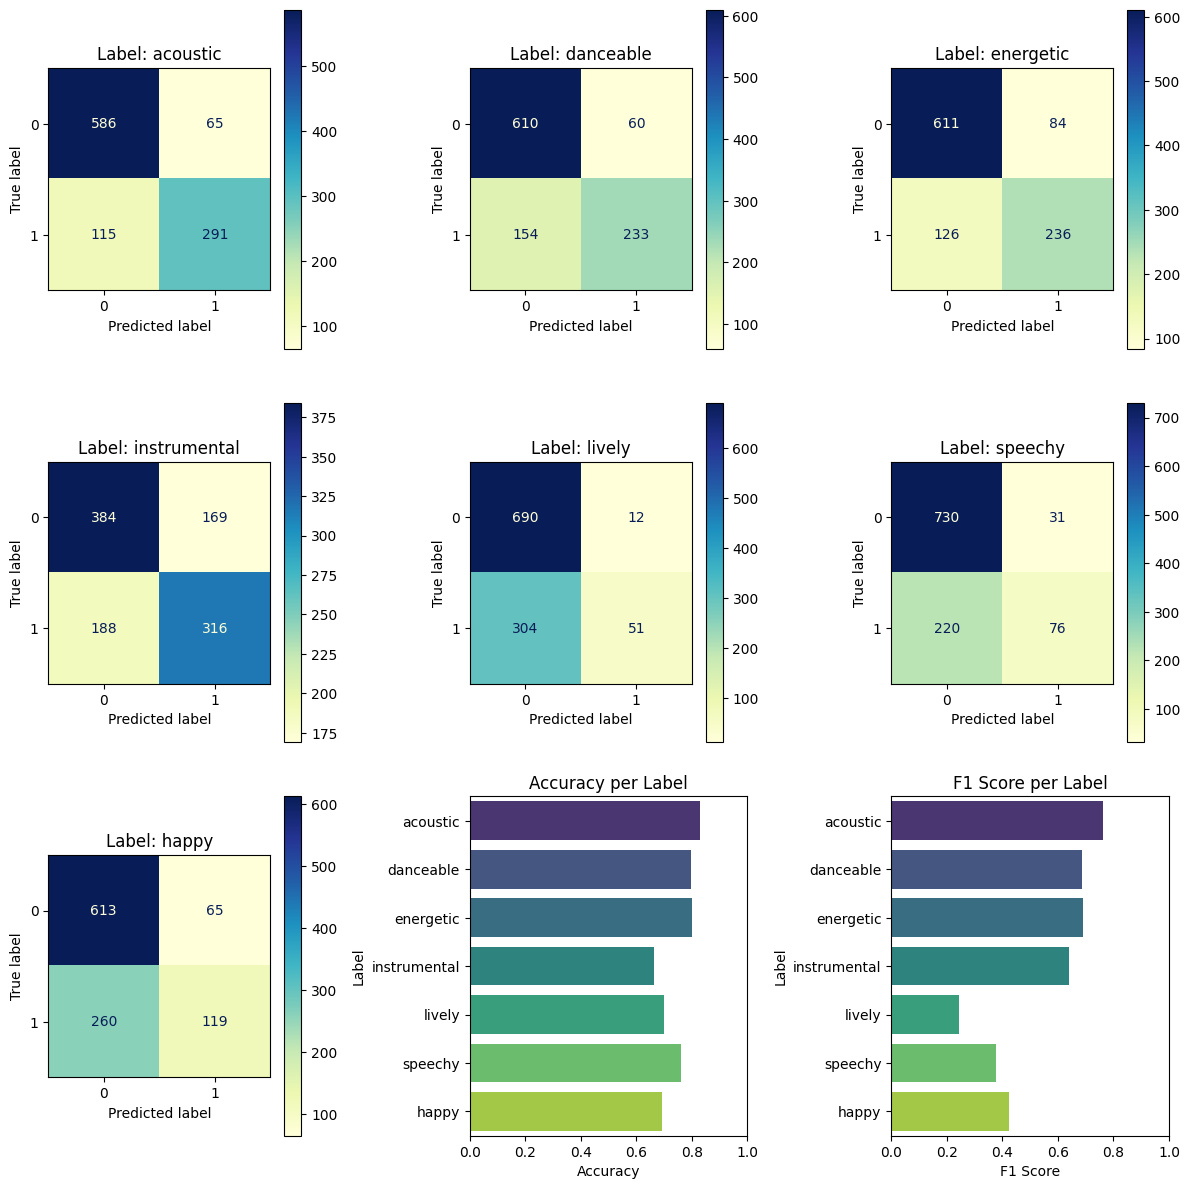

Accuracies:
acoustic: 0.83
danceable: 0.80
energetic: 0.80
instrumental: 0.66
lively: 0.70
speechy: 0.76
happy: 0.69
Average Accuracy: 0.75

F1 Scores:
acoustic: 0.76
danceable: 0.69
energetic: 0.69
instrumental: 0.64
lively: 0.24
speechy: 0.38
happy: 0.42
Average F1 Score: 0.55


In [159]:
labels = list(EN_feature_mapping.values())

print("Random Forest Results:")
eval_classifier(best_rf_model, X_test, y_test, labels)

MLP (Neural Net) Results:


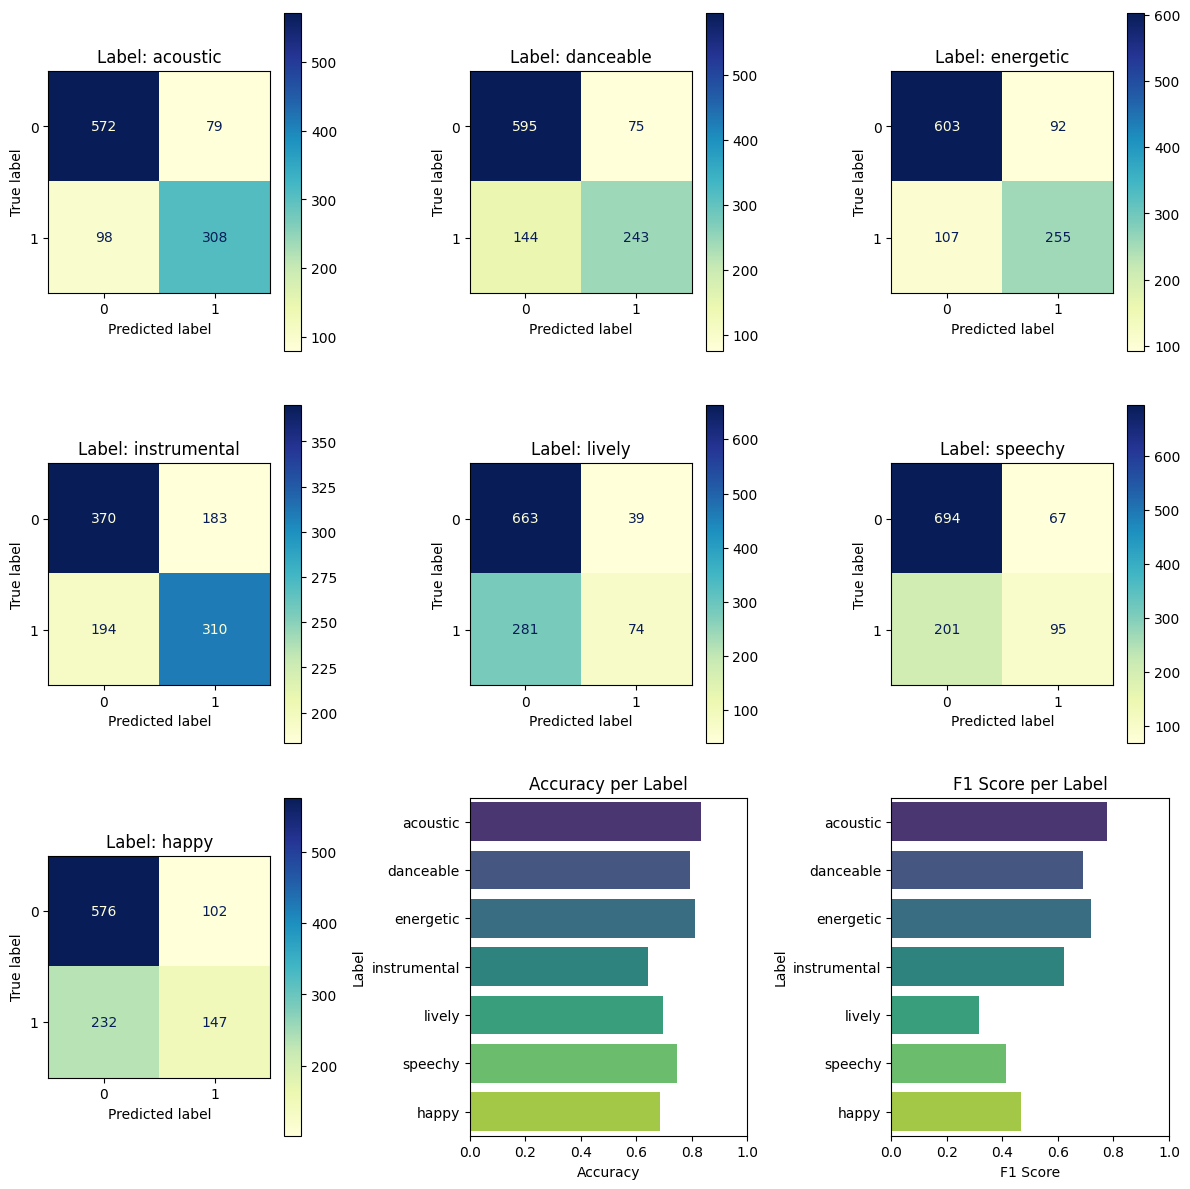

Accuracies:
acoustic: 0.83
danceable: 0.79
energetic: 0.81
instrumental: 0.64
lively: 0.70
speechy: 0.75
happy: 0.68
Average Accuracy: 0.74

F1 Scores:
acoustic: 0.78
danceable: 0.69
energetic: 0.72
instrumental: 0.62
lively: 0.32
speechy: 0.41
happy: 0.47
Average F1 Score: 0.57


In [160]:
print("MLP (Neural Net) Results:")
eval_classifier(best_mlp_model, X_test, y_test, labels)


Evaluating Mean MFCC feature set using Stratified Dummy classifier:


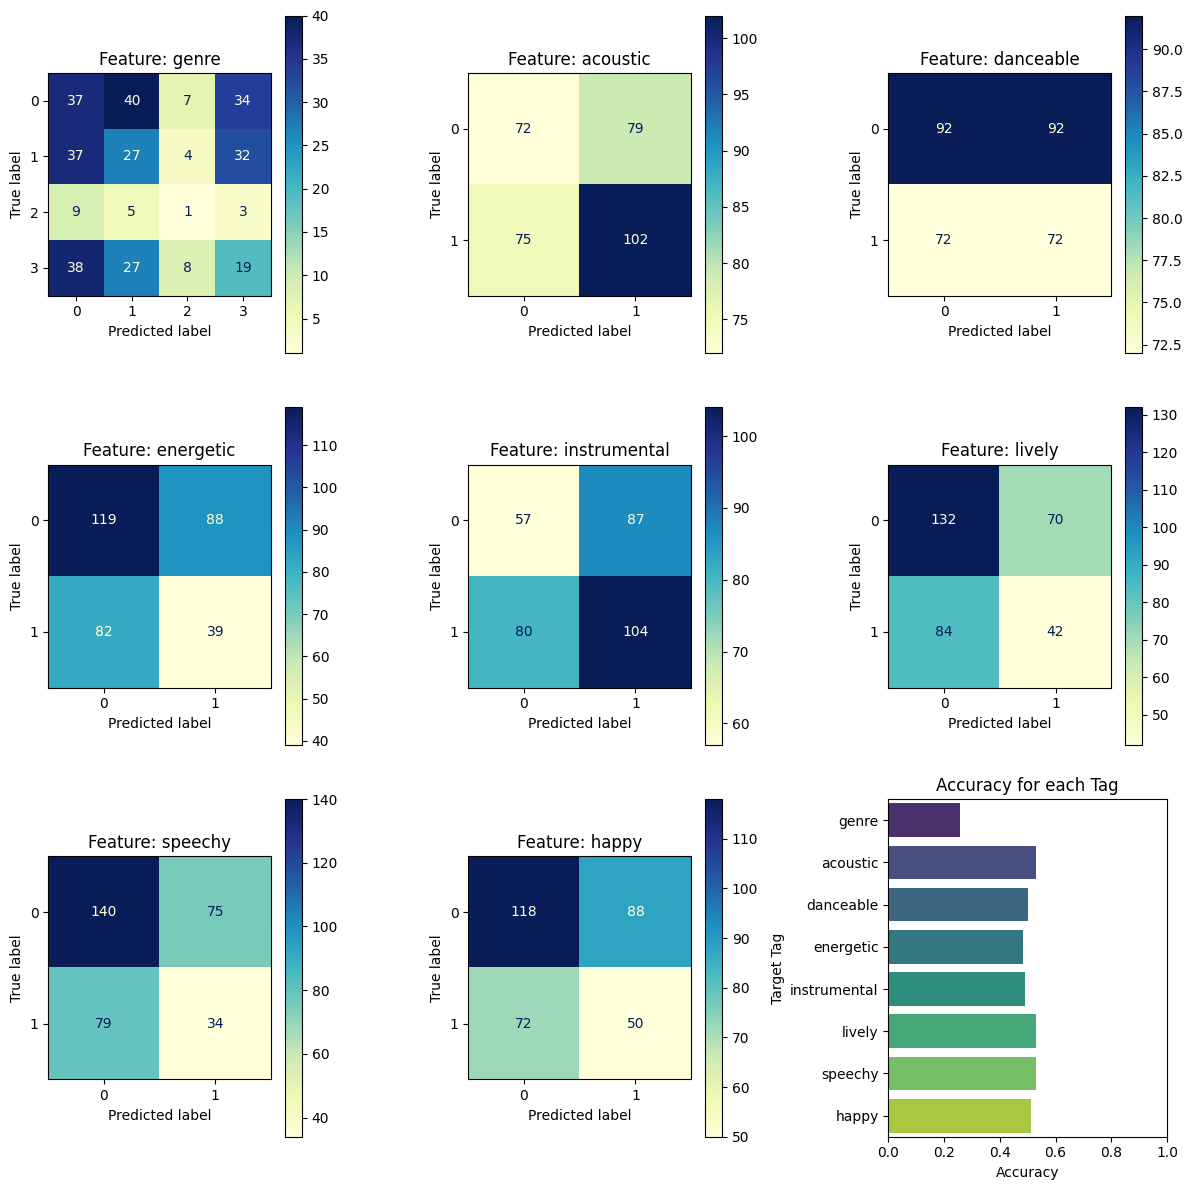

Feature Accuracies:
genre: 0.26
acoustic: 0.53
danceable: 0.50
energetic: 0.48
instrumental: 0.49
lively: 0.53
speechy: 0.53
happy: 0.51

Evaluating Mean & Std MFCC feature set using Stratified Dummy classifier:


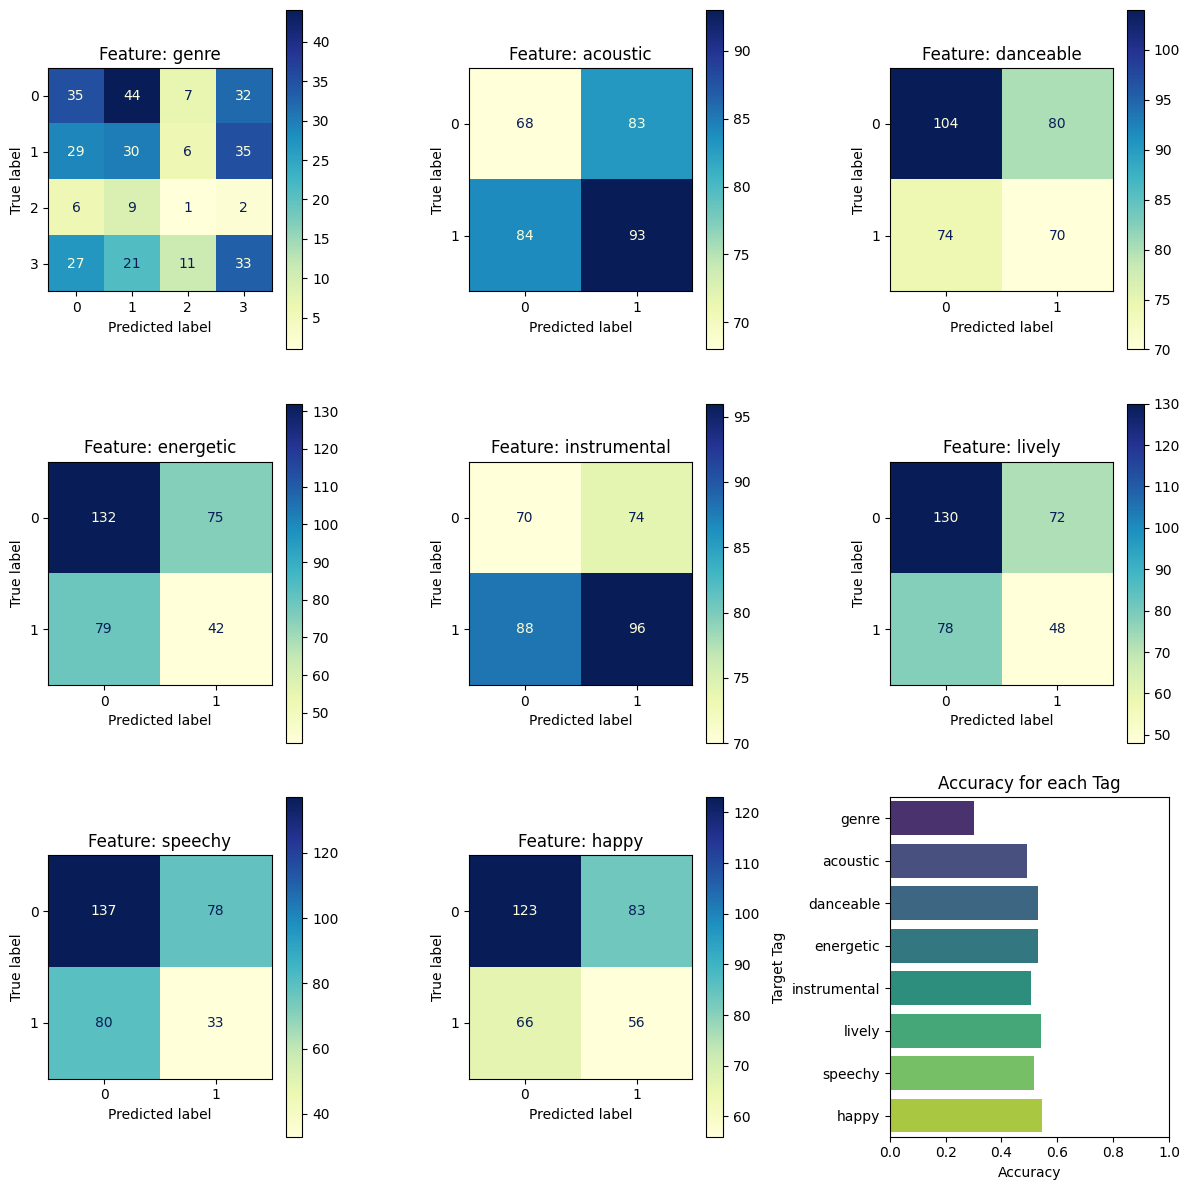

Feature Accuracies:
genre: 0.30
acoustic: 0.49
danceable: 0.53
energetic: 0.53
instrumental: 0.51
lively: 0.54
speechy: 0.52
happy: 0.55

Evaluating Mean Chroma feature set using Stratified Dummy classifier:


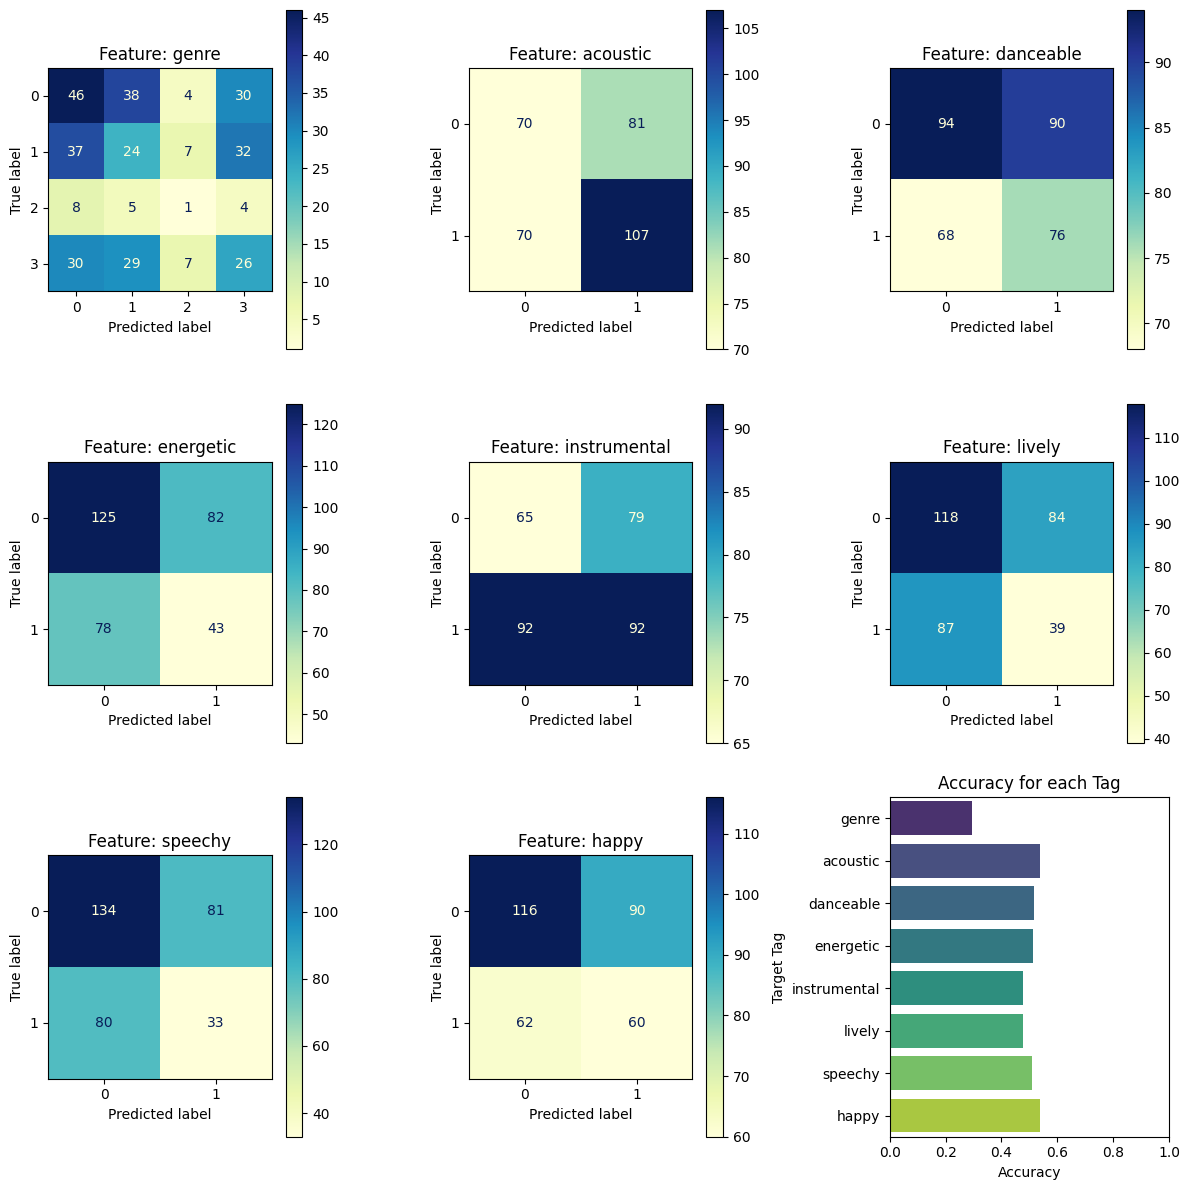

Feature Accuracies:
genre: 0.30
acoustic: 0.54
danceable: 0.52
energetic: 0.51
instrumental: 0.48
lively: 0.48
speechy: 0.51
happy: 0.54

Evaluating Mean & Std Chroma feature set using Stratified Dummy classifier:


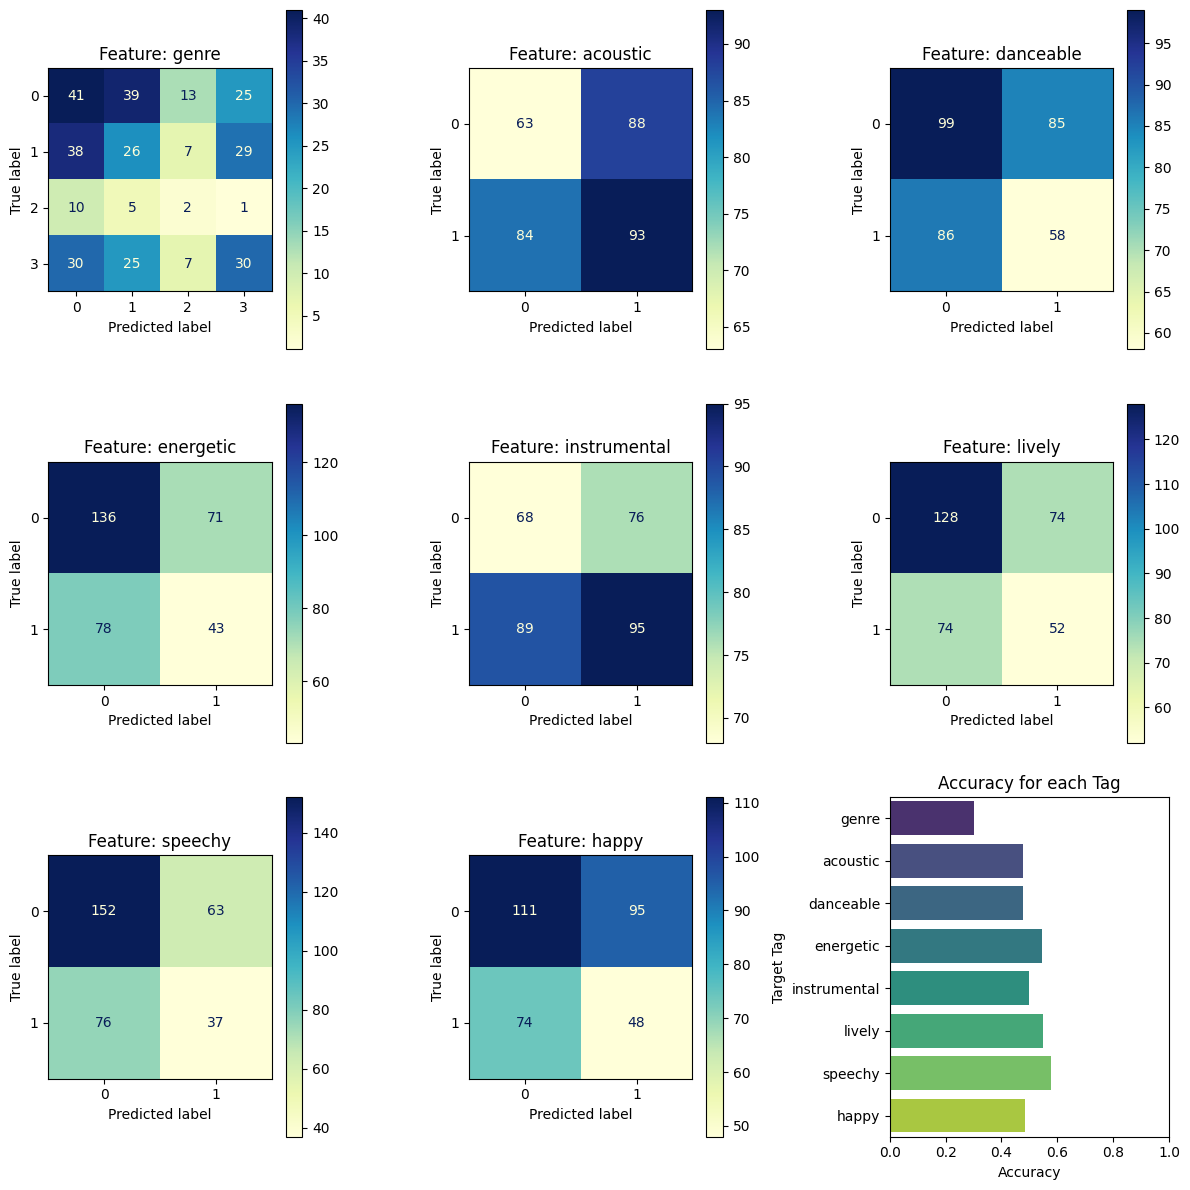

Feature Accuracies:
genre: 0.30
acoustic: 0.48
danceable: 0.48
energetic: 0.55
instrumental: 0.50
lively: 0.55
speechy: 0.58
happy: 0.48

Evaluating Mean MFCC & Chroma feature set using Stratified Dummy classifier:


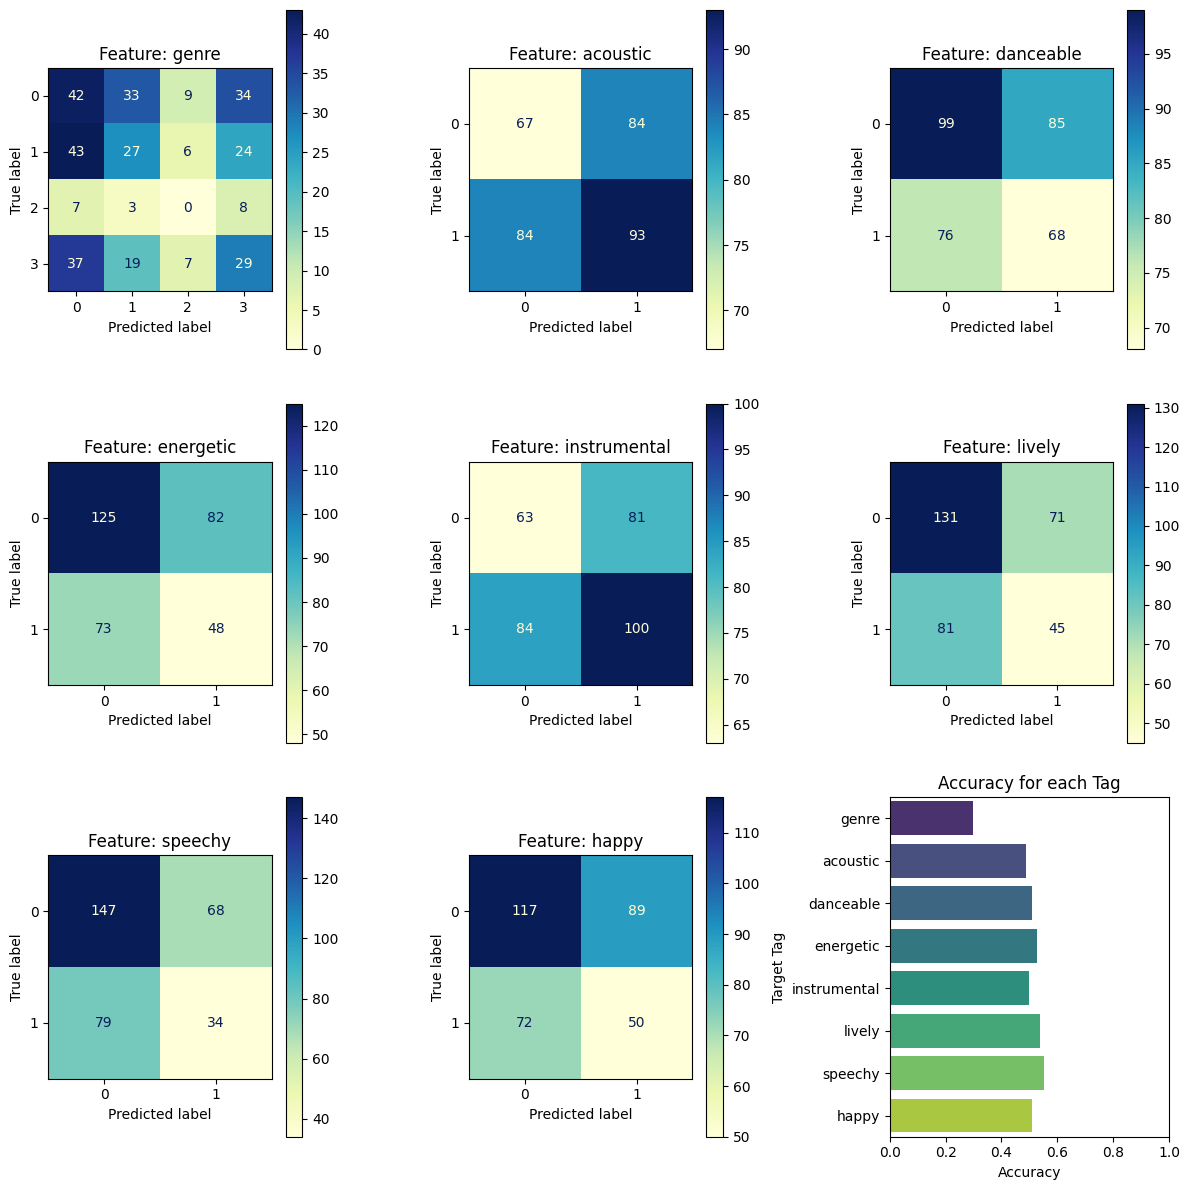

Feature Accuracies:
genre: 0.30
acoustic: 0.49
danceable: 0.51
energetic: 0.53
instrumental: 0.50
lively: 0.54
speechy: 0.55
happy: 0.51

Evaluating Tempo feature set using Stratified Dummy classifier:


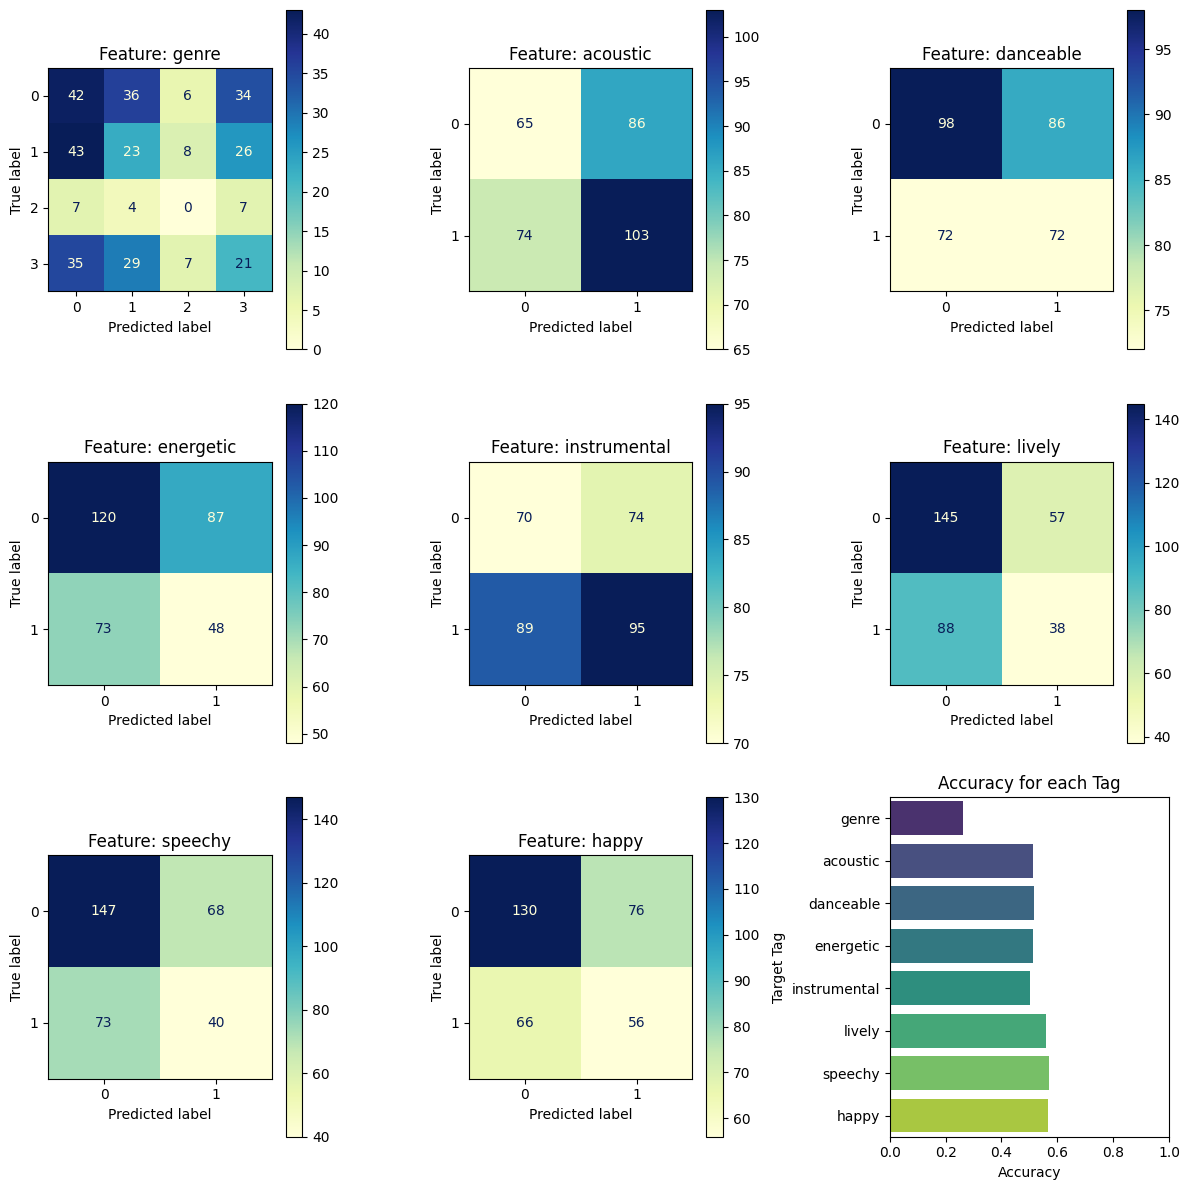

Feature Accuracies:
genre: 0.26
acoustic: 0.51
danceable: 0.52
energetic: 0.51
instrumental: 0.50
lively: 0.56
speechy: 0.57
happy: 0.57

Evaluating Mean MFCC & Tempo feature set using Stratified Dummy classifier:


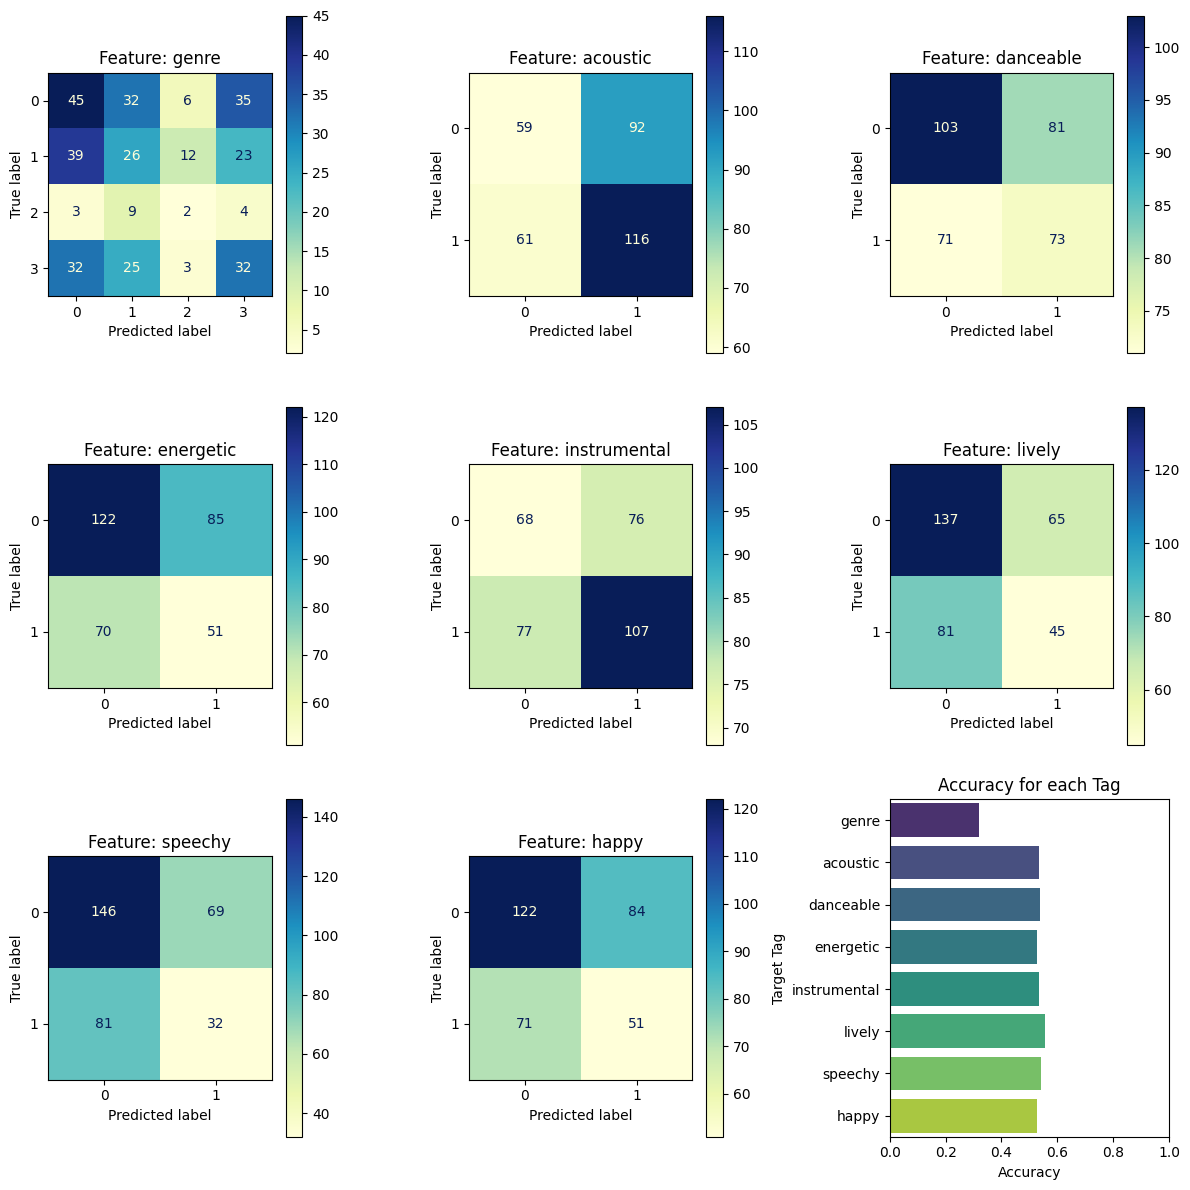

Feature Accuracies:
genre: 0.32
acoustic: 0.53
danceable: 0.54
energetic: 0.53
instrumental: 0.53
lively: 0.55
speechy: 0.54
happy: 0.53

Evaluating All Features feature set using Stratified Dummy classifier:


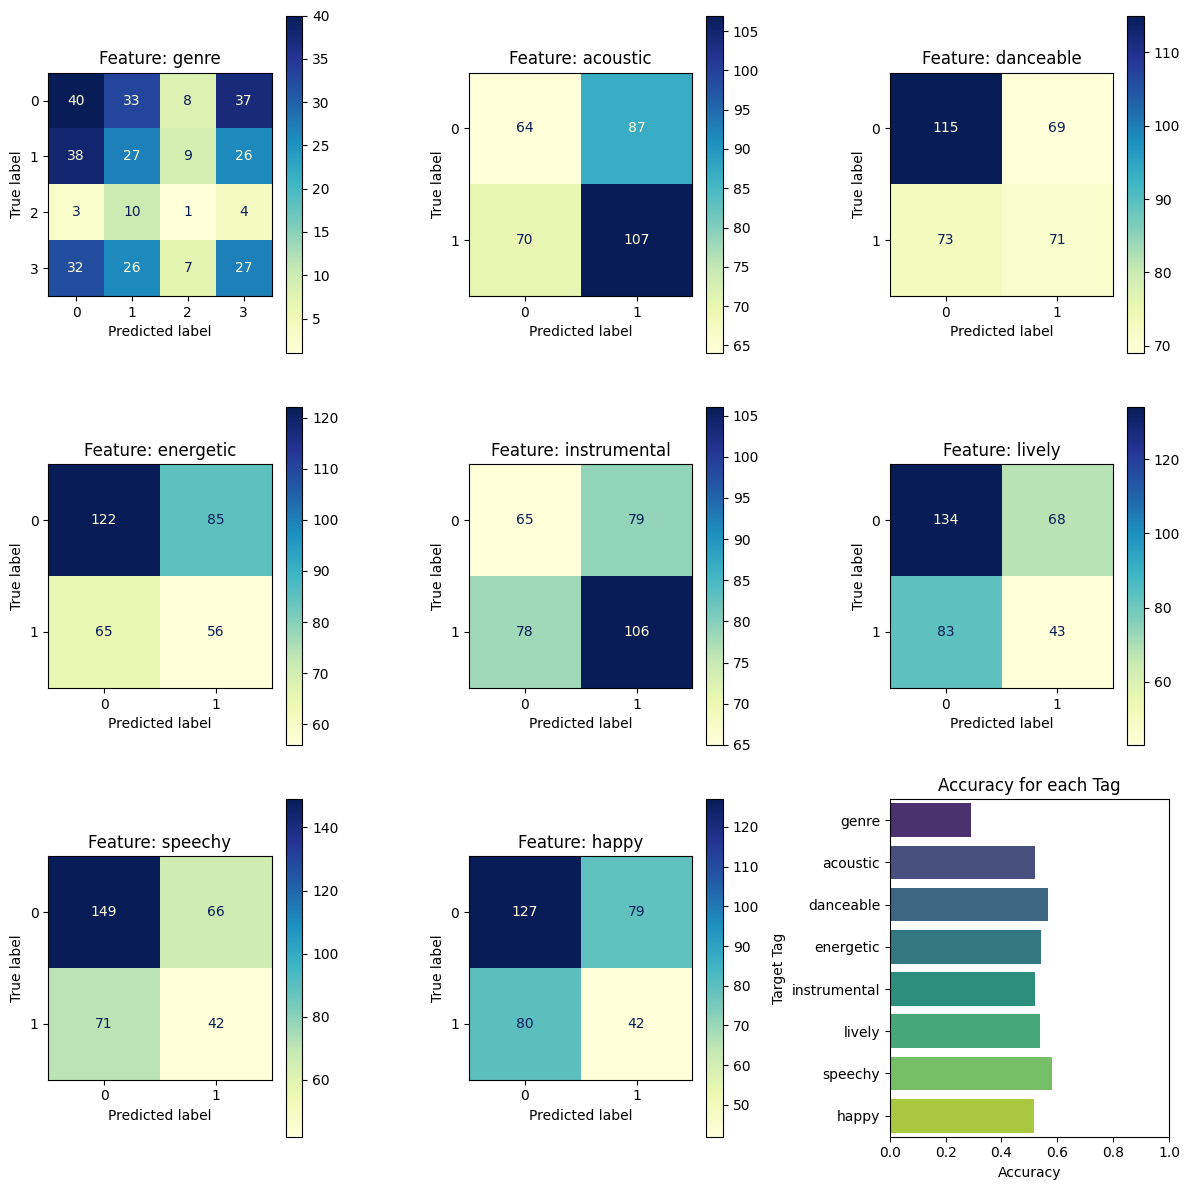

Feature Accuracies:
genre: 0.29
acoustic: 0.52
danceable: 0.57
energetic: 0.54
instrumental: 0.52
lively: 0.54
speechy: 0.58
happy: 0.52


In [50]:
# evaluate stratified dummy classifier as benchmark to compare against
dummy = DummyClassifier(strategy='stratified')
eval_classifier(dummy, X_test, y_test, labels)